In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [16]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

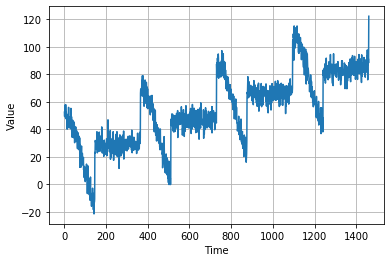

In [17]:
plot_series(time, series)

In [18]:
# Separate train and validation data
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [19]:
# Parameters of the dataset
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Transform the series in tensor
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Trunc the data in a window of size (window_size + 1)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    # Transform them in list
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Separate the inputs and outputs and shuffle the training set
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    # Separate them in batches of batch_size
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [21]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [24]:
# Visualize the data
temp = 0
for x, y in dataset:
    if temp == 5:
        print("x = ", x.numpy())
        print("y = ", y.numpy())
    temp = temp + 1

x =  [[ 86.32665     84.53093     79.05104     86.569954    79.90539
   83.09849     94.98353     81.38736     87.288605    77.69104
   80.686905    89.36113     77.00803     88.83144     82.92502
   76.18184     81.7551      83.04583     80.873344    69.48581   ]
 [ 24.825788    32.809357    29.869114    32.418423    31.52398
   24.252817    25.619074    32.178864    31.51689     28.383394
   29.097626    34.92262     25.599964    31.317053    27.594557
   27.541286    34.147957    32.805748    32.771015    35.255863  ]
 [ 30.450966    26.898535    31.563684    30.338299    27.586983
   23.696756    20.336658    25.659061    32.15494     28.925291
   21.608559    28.686138    29.73035     23.368555    28.541082
   28.048655    22.028439    29.518435    30.52015     33.118732  ]
 [ 53.02789     50.536366    64.142975    58.955788    53.083527
   64.105736    56.444798    61.271942    55.21483     64.67567
   62.6364      52.09588     57.672966    55.509987    58.588013
   46.375916    

In [25]:
# Create a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Define training
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

# Fit on the data
model.fit(dataset, epochs = 100)

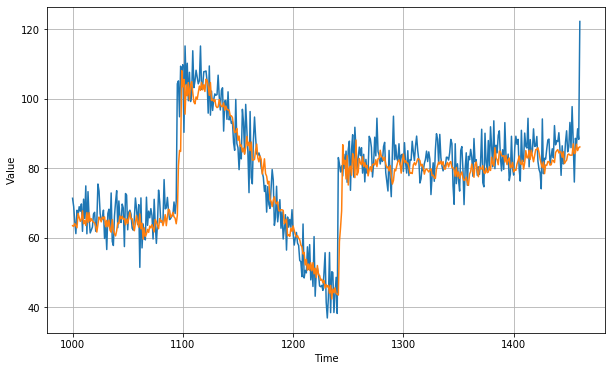

In [26]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.011563

In [29]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

47.386

In [30]:
# Define a new dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [31]:
# Define a new model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"), 
    tf.keras.layers.Dense(10, activation = "relu"), 
    tf.keras.layers.Dense(1)
])

In [32]:
# Define a callbacks for learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [33]:
# Define optimizer
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = "mse", optimizer = optimizer)

In [34]:
# Train
history = model.fit(dataset, epochs = 100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 49ms/step - loss: 2751.2448
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 2653.4099
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 2556.4487
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 2438.2694
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 2345.5558
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 2216.9118
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 2023.2603
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 1676.3912
Epoch 9/100
31/31 [==============================] - 0s 13ms/step - loss: 1190.4710
Epoch 10/100
31/31 [==============================] - 0s 16ms/step - loss: 767.5531
Epoch 11/100
31/31 [==============================] - 0s 13ms/step - loss: 478.4909
Epoch 12/100
31/31 [==============================] - 0s 13ms/step - loss: 3

31/31 [==============================] - 0s 15ms/step - loss: nan
Epoch 100/100
31/31 [==============================] - 0s 13ms/step - loss: nan


[1e-08, 0.001, 0, 300]

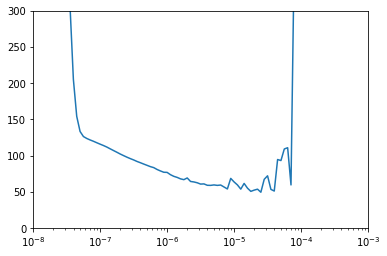

In [35]:
# Plot the loss in function of the learning rate 
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [36]:
# We have now a learning rate that reduces the loss

In [37]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr = 8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500)

Epoch 1/500
31/31 [==============================] - 1s 30ms/step - loss: 110.1814
Epoch 2/500
31/31 [==============================] - 0s 14ms/step - loss: 74.6582
Epoch 3/500
31/31 [==============================] - 0s 13ms/step - loss: 70.1899
Epoch 4/500
31/31 [==============================] - 0s 13ms/step - loss: 64.6918
Epoch 5/500
31/31 [==============================] - 1s 16ms/step - loss: 61.0121
Epoch 6/500
31/31 [==============================] - 0s 14ms/step - loss: 59.3456
Epoch 7/500
31/31 [==============================] - 0s 13ms/step - loss: 61.7850
Epoch 8/500
31/31 [==============================] - 0s 15ms/step - loss: 57.4113
Epoch 9/500
31/31 [==============================] - 0s 13ms/step - loss: 52.3606
Epoch 10/500
31/31 [==============================] - 0s 15ms/step - loss: 56.7231
Epoch 11/500
31/31 [==============================] - 0s 13ms/step - loss: 54.8475
Epoch 12/500
31/31 [==============================] - 0s 13ms/step - loss: 53.0360
Epoch 13/500

31/31 [==============================] - 0s 13ms/step - loss: 37.7883
Epoch 100/500
31/31 [==============================] - 0s 13ms/step - loss: 37.9744
Epoch 101/500
31/31 [==============================] - 0s 14ms/step - loss: 37.1069
Epoch 102/500
31/31 [==============================] - 0s 12ms/step - loss: 37.8497
Epoch 103/500
31/31 [==============================] - 0s 14ms/step - loss: 36.2375
Epoch 104/500
31/31 [==============================] - 0s 14ms/step - loss: 37.0786
Epoch 105/500
31/31 [==============================] - 0s 13ms/step - loss: 39.3125
Epoch 106/500
31/31 [==============================] - 0s 16ms/step - loss: 38.5633
Epoch 107/500
31/31 [==============================] - 0s 14ms/step - loss: 37.9388
Epoch 108/500
31/31 [==============================] - 0s 13ms/step - loss: 39.1104
Epoch 109/500
31/31 [==============================] - 0s 15ms/step - loss: 40.9049
Epoch 110/500
31/31 [==============================] - 0s 15ms/step - loss: 39.7415
Epoch 

31/31 [==============================] - 0s 13ms/step - loss: 35.9203
Epoch 197/500
31/31 [==============================] - 0s 13ms/step - loss: 34.3721
Epoch 198/500
31/31 [==============================] - 0s 14ms/step - loss: 35.1514
Epoch 199/500
31/31 [==============================] - 0s 13ms/step - loss: 37.5864
Epoch 200/500
31/31 [==============================] - 0s 13ms/step - loss: 34.0726
Epoch 201/500
31/31 [==============================] - 0s 12ms/step - loss: 35.3302
Epoch 202/500
31/31 [==============================] - 0s 13ms/step - loss: 34.8234
Epoch 203/500
31/31 [==============================] - 0s 12ms/step - loss: 35.3284
Epoch 204/500
31/31 [==============================] - 0s 12ms/step - loss: 36.2912
Epoch 205/500
31/31 [==============================] - 0s 14ms/step - loss: 38.8306
Epoch 206/500
31/31 [==============================] - 0s 13ms/step - loss: 36.0396
Epoch 207/500
31/31 [==============================] - 0s 12ms/step - loss: 33.9928
Epoch 

31/31 [==============================] - 1s 19ms/step - loss: 38.8277
Epoch 294/500
31/31 [==============================] - 1s 19ms/step - loss: 38.5439
Epoch 295/500
31/31 [==============================] - 1s 20ms/step - loss: 33.7700
Epoch 296/500
31/31 [==============================] - 0s 16ms/step - loss: 35.8972
Epoch 297/500
31/31 [==============================] - ETA: 0s - loss: 33.47 - 1s 18ms/step - loss: 32.9935
Epoch 298/500
31/31 [==============================] - 1s 20ms/step - loss: 35.0066
Epoch 299/500
31/31 [==============================] - 1s 19ms/step - loss: 33.5403
Epoch 300/500
31/31 [==============================] - 0s 16ms/step - loss: 35.2466
Epoch 301/500
31/31 [==============================] - 0s 14ms/step - loss: 35.9751
Epoch 302/500
31/31 [==============================] - 0s 14ms/step - loss: 34.8726
Epoch 303/500
31/31 [==============================] - 0s 15ms/step - loss: 36.5644
Epoch 304/500
31/31 [==============================] - 1s 19ms/ste

31/31 [==============================] - 0s 14ms/step - loss: 33.4116
Epoch 391/500
31/31 [==============================] - 0s 15ms/step - loss: 33.6023
Epoch 392/500
31/31 [==============================] - 0s 15ms/step - loss: 33.0760
Epoch 393/500
31/31 [==============================] - 0s 16ms/step - loss: 36.7406
Epoch 394/500
31/31 [==============================] - 1s 18ms/step - loss: 35.9348
Epoch 395/500
31/31 [==============================] - 1s 19ms/step - loss: 33.9502
Epoch 396/500
31/31 [==============================] - 0s 15ms/step - loss: 30.3367
Epoch 397/500
31/31 [==============================] - 0s 14ms/step - loss: 34.8762
Epoch 398/500
31/31 [==============================] - 1s 17ms/step - loss: 34.1332
Epoch 399/500
31/31 [==============================] - 1s 17ms/step - loss: 33.3761
Epoch 400/500
31/31 [==============================] - 1s 16ms/step - loss: 33.4194
Epoch 401/500
31/31 [==============================] - 1s 16ms/step - loss: 34.6236
Epoch 

31/31 [==============================] - 0s 15ms/step - loss: 33.5812
Epoch 488/500
31/31 [==============================] - 1s 20ms/step - loss: 32.1962
Epoch 489/500
31/31 [==============================] - 1s 19ms/step - loss: 34.4269
Epoch 490/500
31/31 [==============================] - 0s 15ms/step - loss: 33.4682
Epoch 491/500
31/31 [==============================] - 1s 16ms/step - loss: 34.0867
Epoch 492/500
31/31 [==============================] - 0s 15ms/step - loss: 34.1320
Epoch 493/500
31/31 [==============================] - 0s 16ms/step - loss: 33.6716
Epoch 494/500
31/31 [==============================] - 0s 15ms/step - loss: 33.0029
Epoch 495/500
31/31 [==============================] - 1s 18ms/step - loss: 32.7589
Epoch 496/500
31/31 [==============================] - 1s 20ms/step - loss: 33.6675
Epoch 497/500
31/31 [==============================] - 0s 15ms/step - loss: 33.3377
Epoch 498/500
31/31 [==============================] - 0s 14ms/step - loss: 34.3071
Epoch 

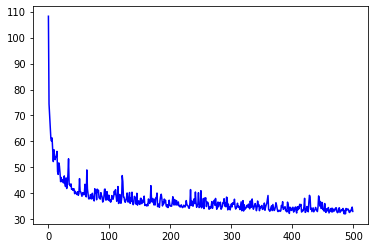

In [38]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

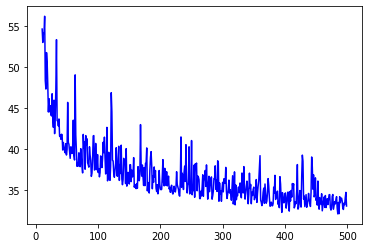

In [39]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

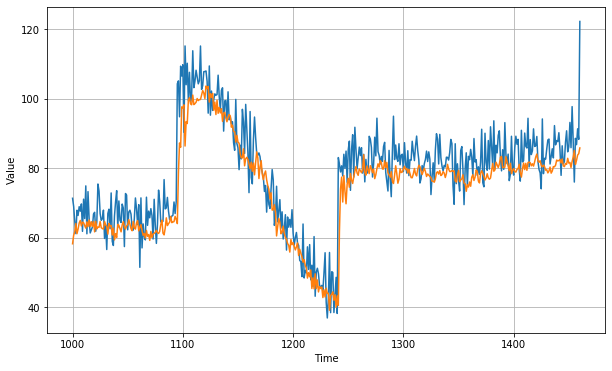

In [40]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [41]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.6793685